# Get feature importance / SHAP values

In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as pl
import ml_help
from time import time
import seaborn as sns
sns.set_theme()

/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/uncle_opal/miniconda3/envs/rapids/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def d

In [3]:
df = pd.read_csv("./data/gardiner_count.csv.zip")
df["datetime_bin"] = pd.to_datetime(df["datetime_bin"], utc=True)
# df.drop(["month","day_of_week"], axis=1, inplace=True)
# df["month"] = df.datetime_bin.dt.month
# df["day_of_week"] = df.datetime_bin.dt.weekday
df["Num. Lanes"] = df["number_of_lanes"]
df["Direction"] = df["direction"]
df["Day"] = df["day"]
df["Hour"] = df["hour"]
df["Minute"] = df["minute"]
df["Dist. Mid Point"] = df["dist_from_mid_point"]
df.drop(["datetime_bin", "number_of_lanes", "direction", "day", "hour", "minute", "dist_from_mid_point"],axis=1,inplace=True)
df

,volume_15min,month,day_of_week,Num. Lanes,Direction,Day,Hour,Minute,Dist. Mid Point
0,160,August,Thursday,3,W,11,15,0,4.887837
1,170,August,Thursday,3,E,11,15,0,0.474912
2,169,August,Thursday,3,E,11,15,0,-0.635254
3,123,August,Thursday,3,W,11,15,0,-0.633557
4,134,August,Thursday,3,W,11,15,0,-7.665465
...,...,...,...,...,...,...,...,...,...
145094,98,January,Sunday,3,E,1,5,15,-7.668009
145095,439,January,Sunday,3,W,1,5,15,0.474912
145096,243,January,Sunday,3,E,1,5,15,0.474912
145097,365,January,Sunday,5,W,1,5,15,-1.750579


In [4]:
categorical_feats = ["Direction","month","day_of_week"]

transformed_df = pd.get_dummies(df, columns=categorical_feats, prefix="", prefix_sep="")
transformed_df = transformed_df.astype("float32")
transformed_df

,volume_15min,Num. Lanes,Day,Hour,Minute,Dist. Mid Point,E,W,August,December,...,November,October,September,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,160.0,3.0,11.0,15.0,0.0,4.887837,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,170.0,3.0,11.0,15.0,0.0,0.474912,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,169.0,3.0,11.0,15.0,0.0,-0.635254,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,123.0,3.0,11.0,15.0,0.0,-0.633557,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,134.0,3.0,11.0,15.0,0.0,-7.665465,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145094,98.0,3.0,1.0,5.0,15.0,-7.668009,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
145095,439.0,3.0,1.0,5.0,15.0,0.474912,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
145096,243.0,3.0,1.0,5.0,15.0,0.474912,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
145097,365.0,5.0,1.0,5.0,15.0,-1.750579,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [5]:
X = transformed_df.drop("volume_15min",axis=1)
y = transformed_df["volume_15min"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.80 = 0.20

# XGBoost

Fitting...
Fitting... OK! Took 16.274115562438965 seconds
Explaining...
Explaining... OK! Took 6.618169546127319 seconds
Calculating shap values...


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Calculating shap values... OK! Took 126.70393872261047 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


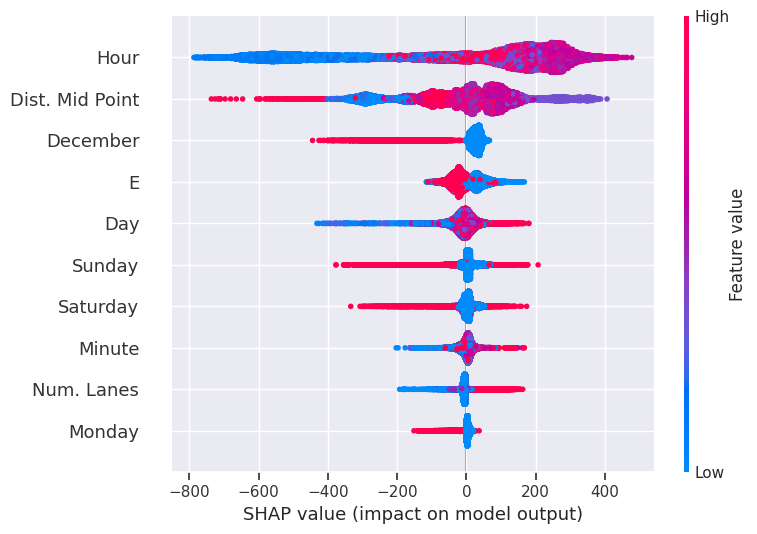

In [8]:
import xgboost as xgb

params = ml_help.params_to_dict("013_xgboost")
params['predictor'] = 'cpu_predictor'
params['tree_method'] = 'hist'
model = xgb.XGBRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test, check_additivity=False)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
xgboost_fig = pl.gcf()
pl.savefig("./plots/016_xgboost.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/016_xgboost.png", bbox_inches="tight")
pl.savefig("./plots/016_xgboost.pdf", bbox_inches="tight")

# Random Forest

Fitting...
Fitting... OK! Took 32.82089638710022 seconds
Explaining...
Explaining... OK! Took 0.013895750045776367 seconds
Calculating shap values...
Calculating shap values... OK! Took 76.76631283760071 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


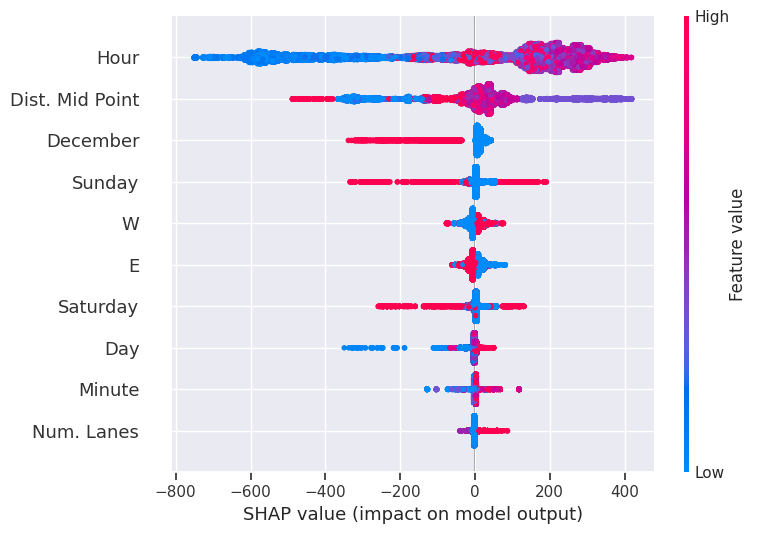

In [9]:
from sklearn.ensemble import RandomForestRegressor

params = ml_help.params_to_dict("013_random_forest")
model = RandomForestRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/016_random_forest.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/016_random_forest.png", bbox_inches="tight")
pl.savefig("./plots/016_random_forest.pdf", bbox_inches="tight")

# Decision Tree

Fitting...
Fitting... OK! Took 0.17145705223083496 seconds
Explaining...
Explaining... OK! Took 0.0008339881896972656 seconds
Calculating shap values...
Calculating shap values... OK! Took 0.2776660919189453 seconds


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


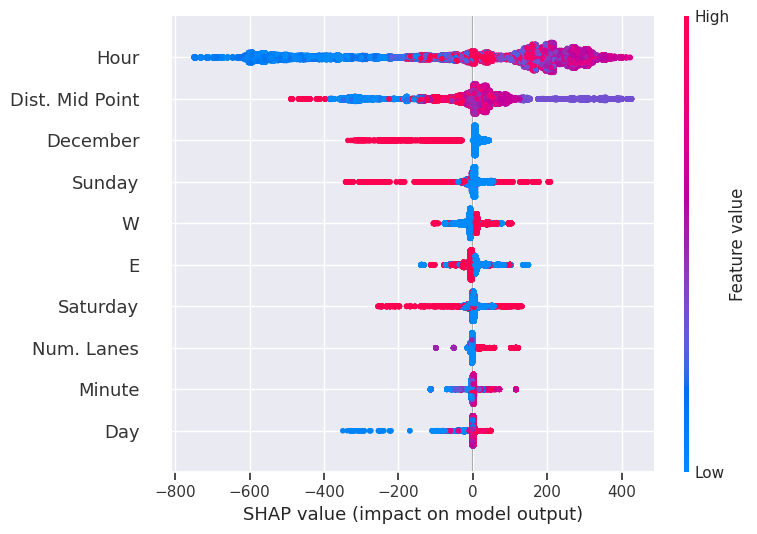

In [10]:
from sklearn.tree import DecisionTreeRegressor

params = ml_help.params_to_dict("013_decision_tree")
model = DecisionTreeRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.TreeExplainer(model)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/016_decision_tree.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/016_decision_tree.png", bbox_inches="tight")
pl.savefig("./plots/016_decision_tree.pdf", bbox_inches="tight")

# MLP

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


Fitting...


X does not have valid feature names, but MLPRegressor was fitted with feature names


Fitting... OK! Took 213.4109013080597 seconds
Explaining...
Explaining... OK! Took 0.0007331371307373047 seconds
Calculating shap values...


100%|█████████████████████████████████████| 29020/29020 [18:57<00:00, 25.51it/s]
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


Calculating shap values... OK! Took 1137.5915722846985 seconds


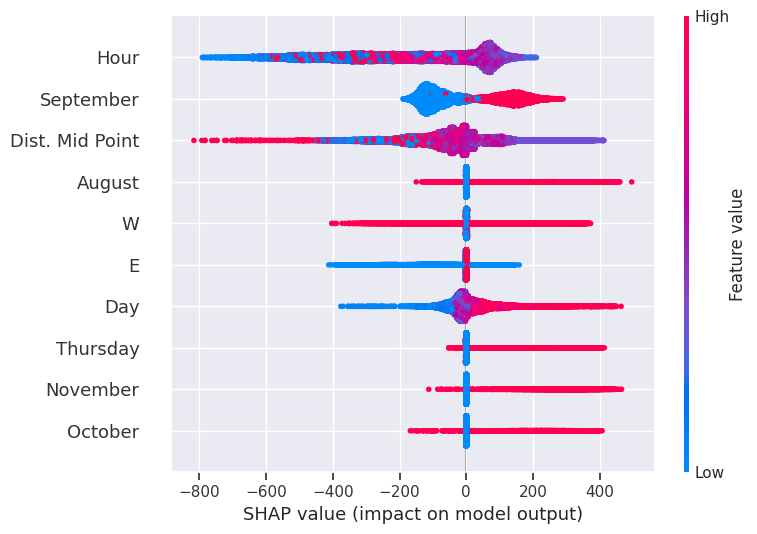

In [11]:
from sklearn.neural_network import MLPRegressor
import warnings

X_train_summary = shap.kmeans(X_train, 10)

params = ml_help.params_to_dict("013_mlpr")
model = MLPRegressor(**params)

print("Fitting...")
start = time()
model.fit(X_train, y_train)
end = time()
print(f"Fitting... OK! Took {end - start} seconds")

print("Explaining...")
start = time()
explainer = shap.KernelExplainer(model.predict, X_train_summary)
end = time()
print(f"Explaining... OK! Took {end - start} seconds")

print("Calculating shap values...")
start = time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    shap_values = explainer.shap_values(X_test)
end = time()
print(f"Calculating shap values... OK! Took {end - start} seconds")

shap.summary_plot(shap_values, X_test, max_display=10, show=False)
pl.savefig("./plots/016_mlp.eps", format="eps", bbox_inches="tight")
pl.savefig("./plots/016_mlp.png", bbox_inches="tight")
pl.savefig("./plots/016_mlp.pdf", bbox_inches="tight")